# Using Pair Potentials Alongside GAP Models - A Tutorial


Hello! 

If you find yourself here, it is likely because you want to learn how to compute pair potentials for dimers, subtract these energies and forces from your dataset of structures, and subsequently run simulations with your pair and GAP potentials. 

If not, I'm afraid you've somehow managed to crawl your way into a very niche area of the vast internet - don't worry, we've all been there, but now it's probably time for you to leave.

In this tutorial, you will learn how to:
1. Compute pair potentials using planewave self-consistent calculations (`pw.x`) via Quantum Espresso and compile them into a LAMMPS-readable format. 
2. Use LAMMPS and the newly-created pair potential to compute energies and forces on your dataset of structures, learning only the correction to our pair potential baseline. 
3. Run simulations with i-PI using the pair potential (through LAMMPS) and your GAP model (through Librascal)

Although I, Victor Principe, Ph.A., have compiled and written this tutorial, the majority of the functions/work for step 1 was written and prepared by Philip Loche, Ph.D., so make sure to go read and cite his work! 

## Some background first...
For some background, let's first explain why this is all necessary. 

When creating your GAP potential, you provide the model with a dataset containing many different configurations and/or systems of interest, hopefully with high fidelity quantum mechanical force and energy data to go along with each snapshot. These snapshots are usually provided from configurational sampling of the system(s) in question. The issue is that these simulations likely did not sample any configurational space where atoms are very close together, as repulsive electrostatic forces should have prevented this from occurring. As the model doesn't know anything about physical principles, it naively extrapolates its model to very small interatomic distances. Instead of having an exponential increase in energy at close distances, with exponentially increasing repulsive forces between the two atoms, it models a decrease in energy/forces down to zero below a certain threshold. 

Now what's the result of this? 

Well, if you subsequently use your GAP potential, and an atom pair pass the aforementioned threshold, the model believes the forces become attractive and the atoms will get cosy and collapse in on each other. Suffice to say the this should *definitely not happen in any universe we live in*. Hence, we need to compute and execute a parallel potential between pairs of atoms that knows how forces and energies behave at small interatomic distances, and thereby "override" the unphysical predictions of the GAP model.

Let's first import some necessary modules for the notebook. Also, please define `basedir` as the path to the directory of the project you are working on. If you would like to run this notebook with the data provided, you can just set `basedir` as the path to the directory in which this notebook is found.

In [1]:
# Import necessary modules
import datetime
import os
from os import makedirs
import warnings
import json
from io import StringIO
from shutil import copy

import pickle
import ase
import ase.io
import ase.io.espresso
from ase.visualize import view
import chemiscope
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from sklearn.linear_model import Ridge
from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.utils import FPSFilter, dump_obj, load_obj
from tqdm.notebook import tqdm
from time import time

In [2]:
#Define a context manager that changes the current working directory
from contextlib import contextmanager


@contextmanager
def cwd(path):
    """
    Simple context manager to temporarily change the current working directory

    Parameters
    ----------
    path : string
           path name of the directory to temporarily change context to
    """
    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

In [3]:
# Define base directory of the project
basedir = os.getcwd()+'/'

# Computing Pair Potentials

As explained above, we first need to compute pair potentials using Quantum Espresso's `pw.x` programme.

In order to do this, we need to run a structure relaxation using every possible combination of element pairs in the system(s) of your dataset. For the purpose of this tutorial, we will be using a dataset of organic molecular crystals containing H, C, N, and O. These structure relaxations will give the energies and forces of atom pairs as a function of their interatomic distance. At the equilibrium spacing, the forces acting on the atoms will be zero, and the energy will reach a minimum.

## Setup System

We first need to set up the systems (i.e. create the `pw.x` input files) for each pair of elements. It is **very important** that you use the **same parameters** during these structure relaxations as were used for the creation of your dataset. Please read the comments in the cells below in order to understand what you may need to change.

In [4]:
workpath = "work_dir/"  # Change this to your working directory

elements = [
    "H",
    "C",
    "N",
    "O",
]  # Elements for which you would like to create pair potentials
L = 13.22  # Length of cubic box used in structure relaxation (13.22 Angstroms are equal to 25 Bohr)

# Create an array of all possible dimer pairs
dimers = []
n_elements = len(elements)
for i in range(n_elements):
    for j in range(i, n_elements):
        dimers.append((elements[i], elements[j]))

# Define Pseudopotentials
pseudo_names = [
    "H.pbe-tm-new-gipaw-dc.UPF",
    "C.pbe-tm-new-gipaw-dc.UPF",
    "N.pbe-n-kjpaw_psl.1.0.0.UPF",
    "O.pbe-n-kjpaw_psl.1.0.0.UPF",
]  # change to the names of your pseudos
pseudopotentials = {i: j for i, j in zip(elements, pseudo_names)}

In [5]:
# Data for pw.x input file -- CHANGE THIS to the parameters used in the curation of your dataset
input_data = {
    "CONTROL": dict(
        calculation="relax",  # we want to do a structure relaxation
        pseudo_dir="../../pseudos/",  # change this to your directory of pseudopotentials
        restart_mode="from_scratch",
        tprnfor=True,
    ),
    "SYSTEM": dict(
        ibrav=1,
        ecutwfc=60.0,
        ecutrho=240.0,
        vdw_corr="dft-d",
        nosym=True,
        occupations="smearing",
        degauss=0.02,
        smearing="mv",
    ),
    "ELECTRONS": dict(conv_thr=1e-10, mixing_beta=0.5),
}

We can now create the input files for the `pw.x` programme (called `pw.in`). 

We will also create Slurm submission scripts for each pair so that the structure relaxations can be run on a server, if need be. Please change the `srun_template.sh` file to suit your needs/cluster if need be. 

In [6]:
# Create directories for each pair of elements, and write pw.in files and Slurm submit scirpts for each -- by Philip Loche
with cwd(workpath):

    with open(
        "../templates/srun_template.sh", "r"
    ) as f:  # Change this to your template path
        srun_template = f.read()

    for dimer in dimers:
        dimer_name = "".join(dimer)

        makedirs(dimer_name, exist_ok=True)  # Create directory for atom pair

        with cwd(dimer_name):

            if "H" in dimer:
                r_min = 0.1  # Use a minimum (starting) distance of 0.1 angstroms for pairs containing Hydrogen
            else:
                r_min = 0.5  # Use a minimum (starting) distance of 0.5 angstroms for all other pairs

            # Create Atoms object with atomic positions and the unit cell
            atoms = ase.Atoms(dimer, positions=[(0, 0, 0), (r_min, 0, 0)], cell=3 * [L])

            # Workaround since ASE does not allow for writing fixed positions
            with StringIO() as fd:
                ase.io.espresso.write_espresso_in(
                    fd,
                    atoms=atoms,
                    input_data=input_data,
                    pseudopotentials=pseudopotentials,
                )
                fd.seek(0)
                pw = fd.read().split("\n")

            pw[-4] += "0 0 0"  # keep one atom stationary
            pw[-3] += "1 0 0"  # only move other atom in the x-direction

            # Write pw.in file
            with open("pw.in", "w") as f:
                f.write("\n".join(pw))

            # Write slurm input file
            with open("srun.sh", "w") as f:
                f.write(
                    srun_template.replace(
                        "job-name=\n", f"job-name={dimer_name}_dimer\n"
                    )
                )

    os.chdir(basedir)

## Run dimer structure relaxations

We can now run structure relaxation for all of our dimer pairs. To do this, you (obviously) need to have a working version of Quantum Espresso (QE) installed on your workstation or server. If you do not have Quantum Espresso installed yet, please go to https://www.quantum-espresso.org to get more information on how to download and compile the programme. I have also provided the necessary outputs to continue this tutorial without needing to run the calculations yourself, if you don't want to go through the effort of compiling QE.

If you would like to run the calculations on your server - assuming it uses Slurm as its job scheduler and resource manager - it's as simple as typing `sbatch srun.sh` in the directory of the dimer. If the server doesn't use Slurm, well, you're out of luck and you will never be able to relax a structure (or yourself). Just kidding, but I can't help you in this case so grab your board and surf the World Wide Web for a solution.

If you would like to run calculations locally, all you need to do is find the path to your `pw.x` exectuable (or better add it to your $PATH), and execute it as `pw.x < pw.in > pw.out`. Or, if you would like to sit back and relax, you can go to your working directory path (which contains all the directories of your atom pairs) and execute:

```console
for i in *
    do cd $i
    echo "Processing dimer $i"
    pw.x < pw.in > pw.out
    wait 
    cd ..
done
```

If your structure relaxation doesn't start, please make sure that you:
- Provided the correct path to `pw.x`
- Provided the correct pseudopotential names
- Attributed the each pseudopotential to the correct species
- Provided the correct `pseudo_dir` in your pw.in input file

## Analyse results
Let's now take a look at some of the dimer relaxation results. 


The LAMMPS pair potential requires the energy and force at the equilibrium spacing to both be equal to zero. As the force will naturally be very close to (or equal to) zero. However, the energy reaches a minimum below zero, and so the energies in each frame will need to be subtracted from the final energy (i.e. baselined). In the case that the final positions is outside the cutoff range, a cosine weighting function can be applied to smoothly sift the tail of the data down to zero. The `cosine_weighting` function (provided by Philip Loche) below applies these transformations. 

As there are relatively few datapoints from the structure relaxation, we should interpolate data within the furthest distance datapoint, and extrapolate to vey short distances, in order to ensure the LAMMPS pair potential is fitted properly. This is done using the `interp1d` function of SciPy.

In [7]:
def cosine_weighting(pos, ener, force, r_cut=2, select=True):  # Written by Philip Loche
    """Weight the energy with cosine so that the energy is 0 at `r_cut`.

      .. math::
          E_n(r) = cos(k r) \cdot E_o(r)

    where :math:`E_n(r)` is the new energy at `r`
    and :math:`E_o(r)` the old energy. Here

      .. math::
          k = \frac{\pi}{2 r_\mathrmn{cut}}

    is the angular frequncy of the cosine. The force is weighted accordingly

      .. math::
          F_n(r) = k sin (k r) \cdot E_o(r) + cos(k r) \cdot F_o(r)

    A warning is raised if :math:`- \partial E_o(r) / \partial r != F_o(r)`

    Parameters
    ----------
    pos : numpy.ndarray
        positions of the energy and the force
    ener : numpy.ndarray
        energy
    force : numpy.ndarray
        force
    r_cut : float
        the position at which the cosine is 0
    select : bool
        return only value for :math:`r<r_\mathrm{cut}`. An additional point
        at `r_cut` is added.
    Returns
    -------
    pos_new : numpy.ndarray
        new positions if select keyword is `True`
    ener_weighted : numpy.ndarray
        cosine weighted energy
    force_weighted : numpy.ndarray
        weighted force
    """

    if pos.shape != ener.shape != force.shape:
        raise ValueError(
            f"Shape of positions {pos.shape},"
            f"energies {ener.shape} forces {force.shape} "
            "do not agree!"
        )

    if np.allclose(-np.gradient(ener, pos), force):
        warnings.warn("Gradient of energy does not agree with given forces!")

    k = np.pi / (2 * r_cut)
    cos = np.cos(k * pos)
    sin = np.sin(k * pos)

    ener_weighted = cos * ener
    force_weighted = k * sin * ener + cos * force

    if select:
        max_index = np.argmin(np.abs(pos - r_cut))

        pos_new = pos[:max_index]
        ener_weighted = ener_weighted[:max_index]
        force_weighted = force_weighted[:max_index]

        pos_new = np.hstack([pos_new, r_cut])
        ener_weighted = np.hstack([ener_weighted, 0])
        force_weighted = np.hstack([force_weighted, 0])

        return pos_new, ener_weighted, force_weighted
    else:
        return ener_weighted, force_weighted

In [8]:
# Importing the pw.out data for all dimers -- by Philip Loche
dimer_ff = (
    {}
)  # Create dictionary of results (positions, energies, forces) for each dimer
r_cut = 2  # choose a maximum cutoff distance for each potential

for dimer in dimers:
    dimer_name = "".join(dimer)
    # Find files
    try:
        frames = ase.io.read(workpath + dimer_name + "/pw.out", ":")
    except FileNotFoundError as err:
        print(err)
        continue
    except AssertionError as err:
        print(f"{dimer_name} AssertionError: {err}")
        continue

    positions = np.zeros(len(frames))
    energies = np.zeros(len(frames))
    forces = np.zeros(len(frames))

    for i, frame in enumerate(frames):
        positions[i] = frame.positions[1, 0]
        energies[i] = frame.get_total_energy()
        forces[i] = frame.get_forces()[1, 0]

    # Subtract final energy from all energies and set last force value to 0
    energies -= energies[-1]
    forces[-1] = 0

    # If positions surpass the max. cutoff distance, sift the energies down to zero using the cosine weighting function
    if positions[-1] > r_cut:  # Å
        positions, energies, forces = cosine_weighting(
            positions, energies, forces, r_cut=r_cut
        )

    # Interpolate results within max. distance and extrapolate results to short distances
    inter_args = dict(fill_value="extrapolate", kind="cubic")

    positions_inter = np.linspace(
        0.01, positions.max(), 100
    )  # create 100 datapoints up to the max. position

    energies_inter_f = interp1d(
        positions, energies, **inter_args
    )  # Function to inter-/extrapolate energies given a distance
    energies_inter = energies_inter_f(
        positions_inter
    )  # Inter- and extrapolate energies based on 100 position datapoints

    forces_inter_f = interp1d(positions, forces, **inter_args)
    forces_inter = forces_inter_f(positions_inter)  # Inter- and extrapolate forces

    forces_inter_derive = -np.gradient(
        energies_inter, positions_inter
    )  # get energy derivatives (i.e. forces) of inter-/extrapolated data

    forces_inter_derive[
        -1
    ] = 0  # make interpolated energy derivative (force) equal to zero

    # Append information to the dimer_ff dictionary
    dimer_ff[dimer] = dict(
        name="".join(dimer),
        positions=positions,
        positions_inter=positions_inter,
        energies=energies,
        energies_inter=energies_inter,
        forces_inter=forces_inter,
        forces_inter_derive=forces_inter_derive,
        forces=forces,
    )

Now let's look at a plot of both the original data (in blue) and the inter- and extrapolated data (in orange) for the H-C dimer. Note that interpolation only occurred within the final original datapoint (at the furthest interatomic distance sampled), and that extrapolation continued at distances under the first original datapoint (the closest interatomic distance sampled).

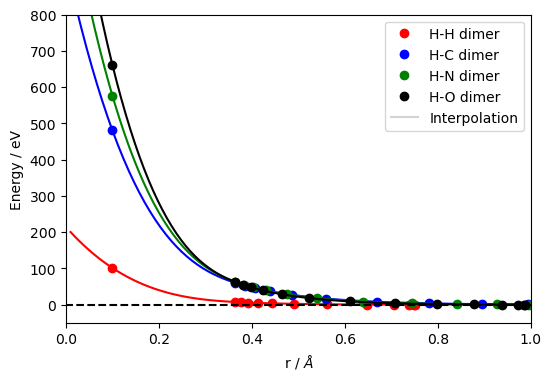

In [9]:
# Plot pair potential interpolated energies for H-containing dimers -- by Philip Loche
plt.figure(figsize=(6, 4), dpi=100)

i = 0
for dimer in dimers:
    colours = ["red", "blue", "green", "black"]
    if "H" in dimer:
        plt.plot(
            dimer_ff[dimer]["positions"],
            dimer_ff[dimer]["energies"],
            "o",
            label=f"{'-'.join(dimer)} dimer",
            color=colours[i],
        )

        plt.plot(
            dimer_ff[dimer]["positions_inter"],
            dimer_ff[dimer]["energies_inter"],
            color=colours[i],
        )
        i += 1

plt.plot(np.nan, np.nan, "lightgrey", label="Interpolation")
plt.hlines(y=0, xmin=-5, xmax=5, linestyle="dashed", color="black")
plt.xlim(0, 1)
plt.ylim(-50, 800)
plt.ylabel("Energy / eV")
plt.xlabel("r / $\AA$")
plt.legend()
plt.show()

That plot looks about right. But we should be careful, for LAMMPS is a smart beast and, if you use these inter-/extrapolated forces and energies to create a pair potential, you will warnings from LAMMPS stating that there are forces that are inconsistent with -dE/dr.

Let's take a closer look at the original forces, the interpolated forces, and the gradients calculated from the interpolated energies and positions, for the H-H dimer.

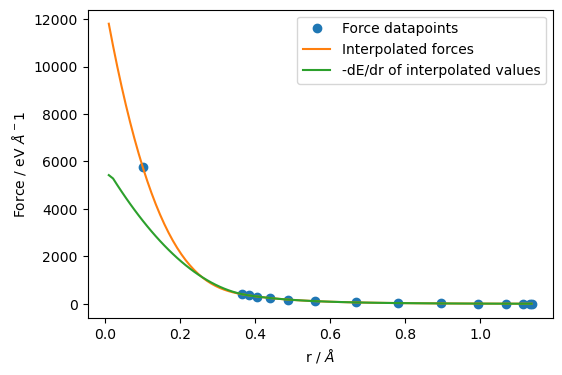

In [10]:
# Plot pair potentialddforces
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(
    dimer_ff[("H", "C")]["positions"],
    dimer_ff[("H", "C")]["forces"],
    "o",
    label="Force datapoints",
)

plt.plot(
    dimer_ff[("H", "C")]["positions_inter"],
    dimer_ff[("H", "C")]["forces_inter"],
    label="Interpolated forces",
)

plt.plot(
    dimer_ff[("H", "C")]["positions_inter"],
    -np.gradient(
        dimer_ff[("H", "C")]["energies_inter"], dimer_ff[("H", "C")]["positions_inter"]
    ),
    label="-dE/dr of interpolated values",
)

plt.ylabel("Force / eV $\AA^-1$")
plt.xlabel("r / $\AA$")
plt.legend()
plt.show()

Ok, so it seems like our interpolated forces match -dE/dr at further interatomic distances, but deviate at short distances. This is what will throw up a warning when running calculations using a pair potential that was created on interpolated forces, instead of using the analytical gradient for the forces in the potential. 

As the main purpose of our pair potential is to only ensure that atoms do not collapse in on one another when they come to close, and to let the GAP model handle the energy/force predictions for the rest, it is not of great importance if the forces calculated at very close distancs are not fully physically accurate - especially as the pair potential will likely cause repulsion before any dimer reaches the short interatomic disance at which the analytical gradients are not fully physically accurate (usually around 0.25 Angstrom).

So let's continue wit creating the pair potential table using the analytical gradients.

## Create Pair Potential Table
We can now create a pair potential through LAMMPS using the data we have. We need to combine the data into a `potential.table` file that we provide to LAMMPS, which contains the positions, energies and forces for each dimer. As explained above, we will use the inter-/extrapolated data to ensure the potential behaves properly. 

In [55]:
# Write potential.table file containing position, energy and force data for each dimer
out = f"# DATE: {datetime.datetime.now().date()}  UNITS: metal\n"
out += "# CONTRIBUTOR: Victor Principe\n"  # Change this to your name!
out += "# Repulsive potential obtained from dimer dissociation using DFT.\n"
out += "# DFT parameters used for Quantum Espresso's planewave self-consistent calculations"
out += " (pw.x):\n" # add DFT parameters to potential.table file
out += f"# - Control parameters: {input_data['CONTROL']}\n"
out += f"# - System parameters: {input_data['SYSTEM']}\n"
out += f"# - Electrons parameters: {input_data['ELECTRONS']}\n"
out += f"# - Pseudopotentials: {pseudopotentials}\n"

for dimer in dimers:
    positions = dimer_ff[dimer]["positions_inter"]
    energies = dimer_ff[dimer]["energies_inter"]
    forces = dimer_ff[dimer]["forces_inter_derive"]

    out += f"\nREPULSIVE_{dimer_ff[dimer]['name']}\n"
    out += f"N {len(positions)}\n\n"  # Add number of datapoints given for each dimer (necessary for LAMMPS)

    for i, (pos, energy, force) in enumerate(zip(positions, energies, forces)):
        out += f"{i:>4d} {pos:>6.8f} {energy:>14.8f} {force:>14.8f}\n"  # Append data

with open(f"potential.table", "w") as f:
    f.write(out)  # write potential.table file

print(out) # Print potential.table file

# DATE: 2022-10-03  UNITS: metal
# CONTRIBUTOR: Victor Principe
# Repulsive potential obtained from dimer dissociation using DFT.
# DFT parameters used for Quantum Espresso's planewave self-consistent calculations (pw.x):
# - Control parameters: {'calculation': 'relax', 'pseudo_dir': '../../pseudos/', 'restart_mode': 'from_scratch', 'tprnfor': True}
# - System parameters: {'ibrav': 1, 'ecutwfc': 60.0, 'ecutrho': 240.0, 'vdw_corr': 'dft-d', 'nosym': True, 'occupations': 'smearing', 'degauss': 0.02, 'smearing': 'mv'}
# - Electrons parameters: {'conv_thr': 1e-10, 'mixing_beta': 0.5}
# - Pseudopotentials: {'H': 'H.pbe-tm-new-gipaw-dc.UPF', 'C': 'C.pbe-tm-new-gipaw-dc.UPF', 'N': 'N.pbe-n-kjpaw_psl.1.0.0.UPF', 'O': 'O.pbe-n-kjpaw_psl.1.0.0.UPF'}

REPULSIVE_HH
N 100

   0 0.01000000   200.32271971  1357.61907574
   1 0.01748059   190.16693219  1332.83890641
   2 0.02496117   180.38188510  1283.75803169
   3 0.03244176   170.96040508  1235.63608484
   4 0.03992235   161.89531880  1188.47306585

# Calculating Energies/Forces in your Dataset

We can now use the newly-created potential to calculate energies and forces in the dataset that was used to create the GAP potential. To illustrate this, we are going to use a dummy dataset called CSD-7, which is a very reduced version the CSD-10k dataset of organic molecular crystals. This dataset contains one geometry-optimised structure and 100 MD structures of 7 unique organic crystals containing only H, C, N and O.

## Create input files
We firstly need to import the data, and then write new LAMMPS structure files for each structure (225k total). Note that the dataset is imported as a dictionary, where each key is the CSD name of the crystal and the value is a list of Atoms objects containing each configuration of the crystal.

In [12]:
# Import dataset
with open("CSD-7.pickle", "rb") as f:
    dataset = pickle.load(f)

In [13]:
# Make directories for each crystal structure and each configuration, and write Lammps structure files
for name in tqdm(dataset.keys(), leave=False, desc="Processing crystals..."):
    for ifrm, frm in enumerate(dataset[name]):
        makedirs(
            f"crystal_data/{name}/{ifrm}/", exist_ok=True
        )  # create directories if they do not exist
        ase.io.write(
            f"crystal_data/{name}/{ifrm}/struct.in",
            frm,
            format="lammps-data",
            specorder=["H", "C", "N", "O"],
        )  # write lammps structure file

print(
    f"Created directories and LAMMPS structure files for {len(dataset.keys())} crystals"
)

Processing crystals...:   0%|          | 0/7 [00:00<?, ?it/s]

Created directories and LAMMPS structure files for 7 crystals


We now need to create a LAMMPS input file to run the single-point calculation for the `struct.in` structure. As all the structure files have been given the same name, we actually only need to create one input file for the `lmp_mpi` (or `lmp_serial`) executable. This is because you can provide all the pair potentials from the previously-created `potential.table` file, and LAMMPS will only use the ones applicable to your system. Similarly, you can provide the mass of all elements (in this case 4 elements - H,C,N, and O) and LAMMPS will only use the masses corresponding to the elements that are present in your system. I know what you're thinking - Wow! Isn't life just easy sometimes? 

So let's make this input file for our crystal systems. If you're curious as to what each line means in the input file, as well as what you may need to change when applying this to your system of choice, please look at the file `templates/lammps_pp.in` and read the comments next to each line.

Pleas be very careful with changing the `specorder` variable above. Atom types will be labelled from 1 to N in the order you provided. If you change the `specorder`, you must also change the atom labels in the first line of the cell below.

In [14]:
atom_labels = {
    "H": 1,
    "C": 2,
    "N": 3,
    "O": 4,
}  # Create dictionary of element-label pairs

# Create LAMMPS input file
lammps = "boundary p p p\n"
lammps += "units           metal\n"  # uses eV, Angstrom, picosend units
lammps += "atom_style      atomic\n\n"

lammps += "read_data       struct.in\n"  # read the struct.in file as the structure

# Add masses of elements to the input file - note that H, C, N, and O are labelled 1, 2, 3, and 4, repsectively
# If you use different elements, be sure to change the associated masses with each element below.
lammps += f"mass    {atom_labels['H']}   1.008\n"
lammps += f"mass    {atom_labels['C']}   12.011\n"
lammps += f"mass    {atom_labels['N']}   14.007\n"
lammps += f"mass    {atom_labels['O']}   15.999\n\n"

# Add the pair potential table to input file
lammps += "pair_style table linear 3000\n"

# You have to separately tell LAMMPS where to find each pair potential table within the potential.table file
# Additionally, you need to give the element labels for which to apply each pair potential you provide
# For example, looking at the first line added to the file here below (open it after executing this cell!), it says:
# That LAMMPS should apply the pair potential table to dimers containing labels 1 and 1 (H and H)
# To open the potential.table file at location /scratch/vprincip/pair_potentials/potential.table
# That LAMMPS should use the table under the section labelled REPULSIVE_HH in the potential.table file
# To only apply the potential up until a cutoff of distance of 0.751 - the max. distance value in the table for HH

for dimer in dimer_ff:
    lammps += f"pair_coeff {atom_labels[dimer[0]]} {atom_labels[dimer[1]]} "
    lammps += f"{basedir}potential.table REPULSIVE_{dimer[0]}{dimer[1]}\n"

lammps += "\ntimestep        1\n"  # This doesn't matter, as we're not running dynamics
lammps += "thermo          1\n\n"

# Write output of forces (and positions) to a file called pp_forces.xyz
lammps += "dump myDump2 all custom 1 pp_forces.xyz type id x y z fx fy fz\n"

lammps += "run 0"  # we only want a single-point calculation

print("#### LAMMPS input file ####\n")
print(lammps)
with open("lammps_pp.in", "w") as f:
    f.write(lammps)

#### LAMMPS input file ####

boundary p p p
units           metal
atom_style      atomic

read_data       struct.in
mass    1   1.008
mass    2   12.011
mass    3   14.007
mass    4   15.999

pair_style table linear 3000
pair_coeff 1 1 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_HH
pair_coeff 1 2 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_HC
pair_coeff 1 3 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_HN
pair_coeff 1 4 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_HO
pair_coeff 2 2 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_CC
pair_coeff 2 3 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_CN
pair_coeff 2 4 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_CO
pair_coeff 3 3 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_NN
pair_coeff 3 4 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_NO
pair_coeff 4 4 /scratch/vprincip/pair_potentials/potential.table REPULSIVE_OO

## Run single-point calculations
Woo! We now have the two files we need to calculate the energies and forces for each structure in our dataset using the newly-created pair potential. As the dataset is small and the potential is very cheap, running these calculations yourself should be pretty fast, even though there are some 700 of them.

If you would like to run the calculations yourself, you will need a working version of LAMMPS. For more information on how to download and compile LAMMPS for your needs, please visit https://docs.lammps.org/Manual.html. Assuming you're not too sadistic, you probably want to run calculations by looping through the entire dataset while muting the typical LAMMPS output. Assuming that the `lmp` executable is in your $PATH, this can be done by going to the `crystal_data` directory of this project and executing the following:

Now sit back, relax, and wait for your calculations to finish! :)

But, if you don't want to wait till then, I offer you another option. Just like the rest of Gen Z, I have little to no patience and enjoy instant satisfaction. That's why I've decided to provide you with the data to just load into this notebook. One could (and should) say that I just invented time travel.

- *For MPI-compiled version of LAMMPS, assuming you have at least 4 cores (change the -np option for more/less cores)*:

```console
for cryst in * 
    do cd $cryst 
    for config in * 
        do cd $config 
        mpirun -np 4 lmp_mpi -in ../../../lammps_pp.in > log.lammps cd .. 
    done 
    echo "Processed crystal $cryst" 
    cd .. 
done
```

- *For the serial-compiled version of LAMMPS*:

```console
for cryst in * 
    do cd $cryst 
    for config in * 
        do cd $config 
        mpirun -np 4 lmp_serial < ../../../lammps_pp.in > log.lammps 
        cd .. 
    done 
    echo "Processed crystal $cryst" 
    cd .. 
done
```


### Process or import results
Let's create a dataset of results, in the form of a dicitonary. 

If you ran the calculations yourself, please execute the next cell.

If you did **not** run the calculations yourself, please skip over the next cell and import the results.

In [15]:
# # For importing your results, if you ran the calculations yourself
# pp_results = {}  # create new database with pair potential results
# i = 0
# j = 0  # keep count of number frames and crystals imported
# for name in tqdm(dataset.keys(), leave=False, desc="Importing results..."):
#     frames = []
#     for ifrm, frm in enumerate(dataset[name]):

#         # read lammps dump file with positions and forces
#         frame = ase.io.read(
#             f"{basedir}crystal_data/{name}/{ifrm}/pp_forces.xyz",
#             format="lammps-dump-text",
#             specorder=["H", "C", "N", "O"],
#         )

#         # get energy from log.lammps output file
#         with open(f"{basedir}crystal_data/{name}/{ifrm}/log.lammps", "r") as file:
#             found = False
#             lines = file.readlines()
#             for iline, line in enumerate(lines):  # read lines of file
#                 if "TotEng" in line and found == False:
#                     energy = float(lines[iline + 1].split()[-2])  # get energy from file
#                     found = True
#             if found == False:  # raise error if energy wasn't found
#                 raise ValueError(
#                     f"Energy not found for configuration {ifrm} of crystal {name}."
#                 )

#         frame.info["Energy (eV)"] = energy  # append energy info to frame
#         frames.append(frame)  # add frame to all frames of the crystal
#         i += 1  # add frame to count

#     pp_results[
#         name
#     ] = frames  # add all frames of the crystal to the database of results
#     j += 1  # add crystal to cound

# print(f"Imported {i} frames over {j} crystals.")

# # Save dataset
# with open("CSD-7_pp_results.pickle", "wb") as f:
#     pickle.dump(pp_results, f)

In [16]:
# (Re)Load dataset, if you didn't run the calculations yourself
with open("CSD-7_pp_results.pickle", "rb") as f:
    pp_results = pickle.load(f)

## Look At Results

Let's look at the forces calculated for a single system ("ABUJUF"). 

In [17]:
# Import all ABUJUF frames with results
ABUJUF_frames = pp_results["ABUJUF"]
# Create an array of all ABUJUF forces
ABUJUF_forces = np.zeros((len(ABUJUF_frames) * len(ABUJUF_frames[0]), 3))
for ifrm, frm in enumerate(ABUJUF_frames):
    ABUJUF_forces[ifrm * len(frm) : (ifrm + 1) * len(frm)] = frm.get_forces()
mean_force_pa = np.mean(ABUJUF_forces, axis=1)

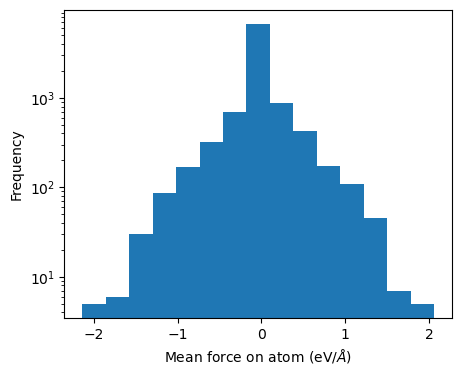

In [18]:
# Plot all forces
plt.figure(figsize=(5, 4), dpi=100)
plt.hist(mean_force_pa, bins=15)
plt.ylabel("Frequency")
plt.xlabel("Mean force on atom (eV/$\AA$)")
plt.yscale("log")

In [19]:
print(
    f"Number of atoms with zero force acting on them: {len(mean_force_pa)-np.count_nonzero(mean_force_pa)}"
)
print(
    f"Percentage of atoms with non-zero force acting on them: {(np.count_nonzero(mean_force_pa)/len(mean_force_pa))*100:.1f}%"
)

Number of atoms with zero force acting on them: 5482
Percentage of atoms with non-zero force acting on them: 43.5%


Now you may be asking yourself: why are there so many forces with a value of zero? 

Well, as you may recall, this potential should only be used when two atoms come into close proximity. That is why we applied a cutoff distance in the LAMMPS input file, which was equal to the maximum distance in the pair potential table for a given dimer. This means that, if a central atom did not have any neighbouring atoms within the cutoff distance of the relevant pair potentials, LAMMPS will have calculated a force of zero for that atom.

But can it really be that over 56% of atoms do not have any atoms within this cutoff? I say yes! Don't believe me? Well good for you, because first and foremost, you shouldn't just believe everything people tell you over the internet (or in person). But also this is science, so we should really look at hard numbers.

Let's look at all the interatomic distances in all the frames, and see how many atoms have at least **one** neighbour within the maximum cutoff distance the corresponding.

In [20]:
# Store a set of cutoff distances to use in the next cell, calculated from the earlier dimers

cutoffs = np.zeros((9, 9), dtype=float)
for i, s in zip([1, 6, 7, 8], "HCNO"):
    for j, t in zip([1, 6, 7, 8], "HCNO"):
        if i <= j:
            cutoffs[i, j] = cutoffs[j, i] = max(dimer_ff[(s, t)]["positions"])

In [21]:
# Count the number of atoms that have neighbours within the relevant cutoff 

within_cutoff = (
    0  # tally of atoms that have at least one neighbour within the relevant cutoff
)
all_atom_centres = 0  # tally of all atoms

for frm in ABUJUF_frames:
    adjacency = frm.get_all_distances(mic=True) - cutoffs[frm.numbers][:, frm.numbers]
    np.fill_diagonal(adjacency, 0)
    within_cutoff += np.count_nonzero(np.min(adjacency, axis=1) < 0)
    all_atom_centres += len(frm)

In [22]:
print(
    f"Total number of atoms with at least one neighbour within the cutoff : {within_cutoff}"
)
print(
    f"Percentage of atoms with at least one neighbour within the cutoff : {(within_cutoff/all_atom_centres)*100:.1f}%"
)

Total number of atoms with at least one neighbour within the cutoff : 4214
Percentage of atoms with at least one neighbour within the cutoff : 43.5%


Which directly corresponds to the 43.5\% of non-zero forces we saw earlier.

## Subtracting pair potential energies and forces from the dataset

Now that we have the pair potential's energy and force calculations, we need to subtract these values from the dataset before creating the GAP model. This is because these energies and forces would essentially be calculated twice during simulations if we kept them in the dataset. If you don't understand why this is necessary, please read this wonderful analogy below.


>*It's like weighing a basket of dolphins. I want to find the sum of masses of all dolphins in the basket. However, my scale is not accurate below a certain (critical) mass, and I have one dolphin that falls below this mass. You, on the other hand, have this fancy scale that is accurate up to this critical mass, but inaccurate above it. So, I give you the light dolphin to weigh, and write down your result. It wouldn't make sense for me to now weigh all the dolphins, as that would mean that your dolphin would be weighed twice. I need to weigh all the dolphins except yours, and then combine results. Voilà - the sum of all the dolphins' mass is equivalent to the total energies and forces in the dataset (previously calculated using DFT-D2), and your dolphin is equivalent to the energies and forces provided by the pair potential. I need to subtract the pair potential energies and forces from the dataset, so that when the two potentials (equivalent to the low and high mass weighing scales) are combined during MD, the energies and forces stack up to the correct sum (total mass of dolphins).*

To simplify things, let's add the force and energy data to our original dataset. When doing this, let's first ensure that the correct information is being added to the correct frame by checking that the positions of the atoms in the original dataset and in the results are equal. To do this, we also need to set the cell parameters of the original dataset equal to that of the results dataset, and wrap atoms inside, as ASE might have applied some transformation to each cell when creating LAMMPS input files.

In [23]:
# Add lammps results to original dataset
for name in tqdm(
    dataset.keys(),
    leave=False,
    desc="Adding LAMMPS force/energy info to original dataset",
):
    for ifrm, frm in enumerate(dataset[name]):
        # ASE might have applied a transformation to the cell when creating LAMMPS input files
        # First need to set the cell lengths and angles equal in the original dataset and then wrap positions
        frame_copy = (
            frm.copy()
        )  # Only check equality on copy of frame, so as to not alter cell of original dataset
        frame_copy.set_cell(pp_results[name][ifrm].get_cell())
        frame_copy.wrap(eps=1e-13)  # wrap atoms inside the unit cell

        # Add lammps results to original dataset only if atom positions in original dataset and results are equal
        if (
            np.allclose(
                pp_results[name][ifrm].get_positions(),
                frame_copy.get_positions(),
                rtol=1e-5,
            )
            == True
        ):
            frm.set_array(
                "pp_forces", pp_results[name][ifrm].get_forces()
            )  # add forces to frame
            frm.info["lammps_pp_energy"] = pp_results[name][ifrm].info[
                "Energy (eV)"
            ]  # add energy to frame

        # Ignore numerical errors where max difference in positions is equal to a cell length (up to 10th decimal)
        elif (
            np.round(
                np.max(
                    pp_results[name][ifrm].get_positions() - frame_copy.get_positions()
                ),
                10,
            )
            in frm.cell.cellpar()[0:3]
        ):
            frm.set_array(
                "pp_forces", pp_results[name][ifrm].get_forces()
            )  # add forces to frame
            frm.info["lammps_pp_energy"] = pp_results[name][ifrm].info[
                "Energy (eV)"
            ]  # add energy to frame

        # Otherwise, raise a ValueError if positions of atoms are not equal
        else:
            raise ValueError(
                f"Positions of atoms are not equal for configuration {ifrm} of crystal {name}."
            )

print("Added LAMMPS pair potential results to the original dataset.")

Adding LAMMPS force/energy info to original dataset:   0%|          | 0/7 [00:00<?, ?it/s]

Added LAMMPS pair potential results to the original dataset.


Let's also append the delta (in both energies and forces) between the original dataset and the LAMMPS pair potential results, so that we don't have to call the operation too often in the future and make all our code look clunky. 

In [24]:
# Add force and energy deltas to each frame
for name in dataset.keys():
    for frm in dataset[name]:
        frm.info["delta_energy"] = (
            frm.info["energy"] - frm.info["lammps_pp_energy"]
        )  # add energy delta
        frm.set_array(
            "delta_forces", (frm.get_array("forces") - frm.get_array("pp_forces"))
        )  # add force delta

In [25]:
# Save original dataset with new pair potential info
with open("CSD-7_combined_w_pp_results.pickle", "wb") as f:
    pickle.dump(dataset, f)

And so we have our dataset! With this, we can now continue on to create a (dummy) GAP potential and run simulations with both the LAMMPS pair potential and the GAP potential. 

# Create GAP Potential
Let's create our GAP potential! Isn't it crazy that the huge conglomerate that is GAP is now essentially getting *free* marketing in the atomistic ML space? I mean the number of GAPs in your city can probably be modelled as a Gaussian distribution with mean 5 - they definitely don't need our help!

Ok, enough of this malarkey, let's get back on track. I assume you already know the basics of how to produce a GAP potential because otherwise you probably wouldn't be here. If that's not the case, I adivse you go delve into any one of the countless papers and tutorials on how to create a GAP potential that can be found online. They will probably explain the theory and creation of them in a far better (and, let's face it, less funny) manner than I ever could.

In this tutorial, we will be using the `librascal` helper tools for creating GAP potentials, which was developed by the COSMO lab at EPFL in Lausanne, Switzerland. Please find the COSMO webpage at https://www.epfl.ch/labs/cosmo/ and follow the installation instructions of `librascal` at https://github.com/lab-cosmo/librascal if you don't already have it installed.

## Create train and test sets, and baselined energy model

First, let's split our dataset into a training set and testing set. We will use a 90:10 train:test split in this case.

In [26]:
# Add all frames in the dataset to a list
dataset_frames = []
for name in dataset.keys():
    dataset_frames.extend(dataset[name])

for frm in dataset_frames:
    frm.wrap(eps=1e-13)  # Necessary to wrap the frames for Librascal later

ids = np.arange(len(dataset_frames))  # Attribute an ID to each frame
np.random.seed(5)  # Use random seed to make results reproducible
np.random.shuffle(ids)  # Shuffle IDs

# Let's use 71 frames (about 10%) for testing, and the rest for training
test_ids = ids[:71]
train_ids = ids[71:]

# Create new train and test sets, as well as energy deltas (y) attributed to both
test_frames = [dataset_frames[num] for num in test_ids]
train_frames = [dataset_frames[num] for num in train_ids]

As it is easier for the model to learn once the energies have been baselined (i.e. the mean per-atom energy is removed for each frame), we need to create a small model to that learns these per-atom energies on the *entire* dataset. To do this, we need to create a matrix that has each structure as its rows and the number of atoms of a certain species in that structure as its columns. We also need to extract the delta energies (y) to be learned. As we will need compositions, delta energies, and forces for our train and test sets later, let's extract those too.

In [27]:
# Create matrix of dataset composition (X_dataset) and energies (y_dataset)
X_dataset = np.zeros(
    (len(dataset_frames), 4), dtype=int
)  # Create empty matrix for compositions
y_dataset = np.zeros(len(dataset_frames))  # Create empty array

for ifrm, frm in enumerate(dataset_frames):
    symbols = frm.get_atomic_numbers()
    X_dataset[ifrm] = [
        len(np.where(symbols == sp)[0]) for sp in [1, 6, 7, 8]
    ]  # Append composition of each frame
    y_dataset[ifrm] = frm.info[
        "delta_energy"
    ]  # Append energy (to be learned) of each frame

In [28]:
# Get train set energies, forces, and composition
X_train = np.zeros(
    (len(train_frames), 4), dtype=int
)  # Create empty matrix for compositions
y_train = np.zeros(len(train_frames))  # Create empty array for train set energies
forces_train = np.zeros(
    (np.sum([len(frm) for frm in train_frames]), 3)
)  # Create empty matrix for train set forces

iat = 0  # Keep count of atoms
for ifrm, frm in enumerate(train_frames):
    symbols = frm.get_atomic_numbers()
    X_train[ifrm] = [
        len(np.where(symbols == sp)[0]) for sp in [1, 6, 7, 8]
    ]  # Append composition of each frame
    y_train[ifrm] = frm.info["delta_energy"]  # Append energy (delta) of the frame
    forces_train[iat : iat + len(frm)] = frm.get_array(
        "delta_forces"
    )  # Append forces of the frame
    iat += len(frm)

# Get test set energies, forces, and composition
X_test = np.zeros(
    (len(test_frames), 4), dtype=int
)  # Create empty matrix for compositions
y_test = np.zeros(len(test_frames))  # Create empty array for train set energies
forces_test = np.zeros(
    (np.sum([len(frm) for frm in test_frames]), 3)
)  # Create empty matrix for train set forces

iat = 0  # Keep count of atoms
for ifrm, frm in enumerate(test_frames):
    symbols = frm.get_atomic_numbers()
    X_test[ifrm] = [
        len(np.where(symbols == sp)[0]) for sp in [1, 6, 7, 8]
    ]  # Append composition of each frame
    y_test[ifrm] = frm.info["delta_energy"]  # Append energy (delta) of the frame
    forces_test[iat : iat + len(frm)] = frm.get_array(
        "delta_forces"
    )  # Append forces of the frame
    iat += len(frm)

In [29]:
# Create small model to baseline energies
mlr = Ridge(alpha=1e-4, fit_intercept=False)
mlr.fit(X_dataset, y_dataset)  # Fit simple ridge regression model

print("Per-atom energies in dataset:")
for spec, coeff in zip(["H", "C", "N", "O"], mlr.coef_):
    print(f"{spec} = {np.round(coeff, 5)} eV/atom")

# Create dictionary of per-atom energies
y_dressed = {}
for i, j in enumerate([1, 6, 7, 8]):
    y_dressed[j] = mlr.coef_[i]

Per-atom energies in dataset:
H = -16.13098 eV/atom
C = -154.84062 eV/atom
N = -383.34328 eV/atom
O = -566.82231 eV/atom


##  Train GAP Potential

In this model, we will use the smooth overlap of atomic positions (SOAP) representation for the crystal structures, with quite cheap hyperparameters. Feel free to adjust these, but to be honest there's only so much milk you can squeeze out of the poor cow that is this dummy GAP model we're creating!

In [30]:
# Define SOAP hyperparameters
hypers = dict(
    soap_type="PowerSpectrum",
    interaction_cutoff=4,  # cutoff distance in angstroms
    max_radial=6,  # no. of radial basis functions
    max_angular=4,  # no. of angular basis functions
    gaussian_sigma_constant=0.4,  # sigma width (i.e. amount of 'smearing')
    gaussian_sigma_type="Constant",
    cutoff_function_type="RadialScaling",
    cutoff_smooth_width=0.5,
    cutoff_function_parameters=dict(rate=1, scale=2, exponent=4),
    radial_basis="GTO",
    normalize=True,
    optimization=dict(Spline=dict(accuracy=1.0e-05)),
    compute_gradients=False,
)
soap = SphericalInvariants(**hypers)  # Define soap using the hyperparameters above

We can now move ahead with computing the features matrices, obtain the sparse points, computing the $K_{NM}$ matrix, and then creating the GAP potential. If you're lazy (or too busy!), you can just skip ahead a few cells and load the test set predictions using the model. 

If you want to create the model yourself, just be aware that calculating the sparse points (`X_sparse`) and the $K_{NM}$ matrix (`Knm`) can take a hop, skip and a jump on time basis... (in human terms, this is equal to 30 minutes on a quad-core Intel Xeon E3 CPU).

In [31]:
# # Compute feature matrices
# manager_train = soap.transform(train_frames)  # calculating features
# print("Computed feature matrices.")

In [32]:
# # Use an FPS filter to obtain 1000 sparse points per species (this may take a minute)
# nsparse = {1: 1000, 6: 1000, 7: 1000, 8: 1000}  # Get 1000 sparse per species
# compressor = FPSFilter(soap, nsparse, act_on="sample per species")  # Define the filter

# print("Sparsifying training set...")
# start = time()
# X_sparse = compressor.select_and_filter(manager_train)  # Apply filter to training set
# print("Done. Time taken:", time() - start, "s")

In [33]:
# # Redefine hypers
# hypers[
#     "compute_gradients"
# ] = True  # We want to compute gradients (forces) for the kernel
# soap = SphericalInvariants(**hypers)  # Redefine soap with updated hypers
# kernel = Kernel(
#     soap, name="GAP", zeta=2, target_type="Structure", kernel_type="Sparse"
# )  # Define Kernel

In [34]:
# # Compute the K_NM matrix (this will take a while!)
# start = time()
# Knm = compute_KNM(
#     tqdm(train_frames, desc="Compute KNM", leave=False), X_sparse, kernel, soap
# )  # Compute K_NM
# print(f"Computed K_NM matrix. Time taken: {time()-start} s")

In [35]:
# # Save the K_NM matrix and the sparse points
# makedirs("gap_data/", exist_ok=True)
# dump_obj("gap_data/X_sparse.json", X_sparse)  # Save sparse points
# np.save("gap_data/Knm_matrix", Knm)  # Save Knm matrix

In [36]:
# # Load the K_NM matrix and the sparse points - only in case of re-training the model
# X_sparse = load_obj("gap_data/X_sparse.json")
# Knm = np.load("gap_data/Knm_matrix.npy")

And now we train the GAP potential, and save it a file to be used in our simulations!

In [37]:
# # Train GAP model
# print("Training GAP model...")
# start = time()
# model = train_gap_model(
#     kernel,
#     train_frames,
#     Knm,
#     X_sparse,
#     y_train,
#     y_dressed,
#     grad_train=-forces_train,
#     lambdas=[0.01, 0.1],
#     jitter=1e-9,
# )
# print(f"Done. Time taken: {time()-start}s")

# # Save model
# dump_obj("GAP_model.json", model)
# print("Model saved.")

Woop dee doop, we have our model and pair potential, and hence we can now use these two in parallel to run simulations using our favourite universal force engine: i-PI!

But before we do that, let's make sure that the model is working correctly by making force and energy predictions on the test set we created earlier.

In [38]:
# Predict energies and forces for test set
#
#y_pred = []  # create empty list for energy predictions
#forces_pred = []  # create empty list for forces predictions
#
#start = time()
#
#for ifrm, frm in enumerate(
#    tqdm(test_frames, desc="Making predictions for test set...", leave=False)
#):
#    manager_test = soap.transform(frm)  # Calculate SOAP feature vectors
#    y_pred.append(model.predict(manager_test))  # Predict energies
#    forces_pred.append(model.predict_forces(manager_test))  # Predict forces
#
#print(
#    f"Time taken for making energy and force predictions on {len(test_frames)} frames: {time()-start} s"
#)
#
## Transform results into suitable form for later
#y_pred = np.array(y_pred).flatten()
#forces_pred = np.concatenate(forces_pred)
#
## Save prediction results
#np.save('gap_data/y_pred.npy', y_pred)
#np.save('gap_data/forces_pred.npy', forces_pred)

### For those who have skipped ahead -- **reload the test set predictions here**.

In [39]:
# Load test set predictions
y_pred = np.load('gap_data/y_pred.npy') #Load the y (energy) predictions
forces_pred = np.load('gap_data/forces_pred.npy') #Load the force predictions

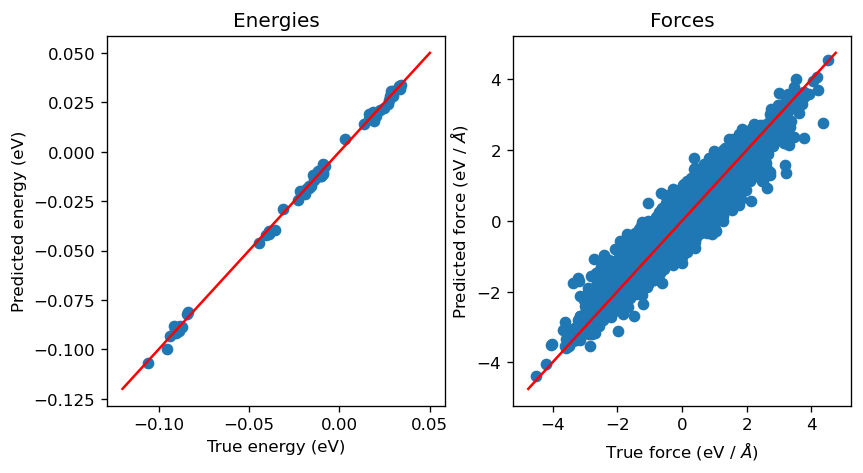

In [40]:
# Plot predicted vs. actual energies and forces for the test set

# Calculate baseline and number of atoms for each frame
baseline = mlr.predict(X_test)
n_atoms = np.sum(X_test, axis=1)

f,p = plt.subplots(1,2, figsize = (8, 4), dpi=120)
p[0].scatter((y_test - baseline)/n_atoms, (y_pred - baseline)/n_atoms) #plot energies
p[0].plot([-0.12, 0.05], [-0.12, 0.05], c='red') #plot x=y line
p[0].set_title('Energies')
p[0].set_xlabel('True energy (eV)')
p[0].set_ylabel('Predicted energy (eV)')
p[1].scatter(forces_test.flatten(), forces_pred.flatten()) #plot forces
p[1].plot([-4.75, 4.75], [-4.75, 4.75], c='red') #plot x=y line
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (eV / $\AA$)')
p[1].set_ylabel('Predicted force (eV / $\AA$)')
plt.show()

In [41]:
print(
    f"Energy RMSE: {np.sqrt(np.mean(((y_test - baseline)/n_atoms - (y_pred - baseline)/n_atoms)**2))} eV/atom"
)
print(
    f"Force RMSE: {np.sqrt(np.mean((forces_test.flatten() - forces_pred.flatten())**2))} eV/Angstrom"
)

Energy RMSE: 0.0017761006716161222 eV/atom
Force RMSE: 0.2477146452080332 eV/Angstrom


Don't worry about the small tropical islands in the energies above - that's just because we've only used seven crystals in our training and test sets, and configurations of the same crystal have similar binding energies. All in all, the force and energy predictions actually seem pretty great! But don't give the model too much credit - these are predictions on novel configurations of the same crystals the model was trained on. I'm sure if we made predictions on organic crystals outside the training set it would perform more poorly than Jeff Bezos's tax returns. 

# Running Simulations with i-PI

We will be running path integral molecular dynamics (PIMD) using the true and tested software of i-PI. Words can't explain how good i-PI is for running PIMD. Honestly, I wish I could rationally explain the beauty of its code, but I can't. After all, PI is irrational! So you'll have to see it to believe it. If you haven't got a working version of i-PI, you can read more about it and follow the download instructions at http://ipi-code.org.


## Prepare simulation files

So, let's run simulations on the same crystal we were looking at earlier, which goes by the name of "ABUJUF". The i-PI input template can be found at `templates/i-pi_input.xml`, and the LAMMPS input can be found at `templates/lammps_md.in`. Let's run dynamics starting from a random ABUJUF configuration, let's say 11. Feel free to change this to your favourite number! The `struct.in` file from this configuration will be added to the `ABUJUF_PIMD/` directory, as that is where we will run simulations. The `lammps_md.in` and `i-pi_input.xml` files have already been added to the directory. 

We need to create an i-PI-readable structure in XYZ format, as well as a Librascal-readable structure in extended-XYZ format, which we can create here below using ASE.

In [42]:
# Write frame in extended XYZ format for Librascal, and copy LAMMPS-readable frame to the simulation directory
configuration = 11  # choose starting configuration
copy(
    f"crystal_data/ABUJUF/{configuration}/struct.in", f"ABUJUF_PIMD/struct.in"
)  # copy structure file to simulation directory

frame = dataset["ABUJUF"][configuration].copy()  # get copy of frame
frame.set_array("forces", None)  # Remove forces from frame
cell = frame.cell.cellpar()

# Write i-PI-readable format
ase.io.write(
    "ABUJUF_PIMD/struct.xyz",
    frame,
    format="xyz",
    comment=f"# CELL(abcABC): {' '.join([str(c) for c in cell])}"
    " positions{angstrom} cell{angstrom}",
)

# Write Librascal-readable format
ase.io.write(
    "ABUJUF_PIMD/struct.extxyz",
    frame,
    format="extxyz",
    columns=["symbols", "positions"],
    write_info=False,
)  # Write frame with only positions information

Let's quickly take a look at the `i-pi_input.xml` file. If you understand how to read the file, then great! Otherwise, please follow the link above and do some googling to figure out what each line means. Don't want to? Fine, I'll tell you the gist of what it says. 

We will be running simulations in the NVT ensemble at 300 K for 100 steps. We will be using only 4 beads for this simulation, just to speed things up. Please note that if you want to run proper statistical sampling, you should use 32 beads for full PIMD (or you can use 6 beads with a PIGLET thermostat). If you look at the `<ffsocket>` sections of the input, you will see that we are using two drivers. The first is the LAMMPS pair potential, which has been attributed to the socket address `lammps`. The second is the GAP potential, which has been attributed to the socket address `gap`. Under the `<forces>` section of the input, it says that each potential has been given a weighting of `1.0`. This is because the LAMMPS energies and forces were subtracted from the dataset used to train the GAP potential, and so the predictions from the two potentials must be summed during simulations to give the total energies and forces.

Lastly, to simplify things, I've created a job script that we can just bash to start and run our simulation. If you open up the file, the comments next to each line explain what each line does. Let's just take a closer look at the lines which start up the two potentials:

In [43]:
# Read lines of run.sh file
with open("ABUJUF_PIMD/run.sh", "r") as f:
    for iline, line in enumerate(f.readlines()):
        if iline == 4 or iline == 6:
            print(line)

lmp_mpi -in lammps_md.in > log.lammps & # Start the LAMMPS driver, output log to "log.lammps"

i-pi-py_driver -u -a gap -m rascal -o ../GAP_model.json,struct.extxyz > log.gap & # Start the Librascal driver, output log to "log.gap"



The first line starts up the LAMMPS pair potential that we created in the first part of this tutorial. Please note that you may have to change `lmp_mpi` to the path of your LAMMPS executable, unless it is already in your path. Secondly, in the `lammps_md.in` file, you should make sure that the socket address (`lammps`) in the `fix 1 all ipi `**`lammps`**`  1234 unix` line is the same as the LAMMPS socket address in the i-PI input file  (it should be, unless you've changed something...).

The second line starts up the Librascal GAP potential we created in the third part of this notebook. The `-a `**`gap`** option specifies that the socket address it should be attributed to is `gap`. The `-o ../../GAP_model.json,struct.extxyz` option should specify the path to the GAP potential and the Librascal-readable (extended XYZ) input structure, which should be comma-separated.

## Run Simulation

Here we are! You can now execute a simple `bash run.sh` in the `ABUJUF_PIMD/` directory and watch those atoms jiggle! (Ok you won't actually see them jiggle, but use your imagination to picture it! Or  better, get some groovy tunes on and jiggle yourself to get in the simulation mood!)

Please note that this will probably take a few minutes. You can also monitor the progress of the simulation by either opening a new terminal window, going to the simulation directory, and executing `tail -f simulation.out`.

Once it's done, let's take a look at the simulation output and positions of the first replica - `simulation.out` and `simulation.pos_0.xyz`. If you ran the simulation, but your dog accidentally licked your hard drive and perfectly destroyed the bytes pertaining to the simulation, you can skip the next cell and load the files `sim_copy.out` and `sim_copy.pos_0.xyz`. These are copies of simulation output files for configuration 11. We can then use our favourite widget, Chemiscope, to view the trajectory. If you haven't done so yet, please install the chemiscope package with a simple `pip install chemiscope`.If you would like to find out more about the chemiscope project, please read further at https://chemiscope.org.

In [44]:
## Read trajectory - if you ran the simulation yourself
#trajectory = ase.io.read("ABUJUF_PIMD/simulation.pos_0.xyz", ":")
#sim_outfile = "ABUJUF_PIMD/simulation.out"

In [45]:
# Read trajectory - if the dog destroyed simulation
trajectory = ase.io.read("ABUJUF_PIMD/sim_copy.pos_0.xyz", ":")
sim_outfile = "ABUJUF_PIMD/sim_copy.out"

In [46]:
# Create dataframe with properties of simulation and create dictionary for chemiscope
with open(sim_outfile) as f:
    headers = []  # create array for headers of dataframe
    for line in f.readlines():
        if line.startswith("#"):
            headers.append(
                line.split(sep="--> ")[1].split(sep=" : ")[0]
            )  # get names of headers

# create dataframe
props = pd.read_csv(
    sim_outfile, delimiter="    ", skiprows=6, names=headers, engine="python"
)
properties = props.to_dict(orient="list")  # convert dataframe to dictionary

print("Properties of the ABUJUF simulation:")
props  # display dataframe

Properties of the ABUJUF simulation:


,step,time{picosecond},potential{electronvolt},conserved,temperature{kelvin},ensemble_temperature{kelvin}
0,0.0,0.0000,-21034.2074,-772.956025,23.362681,300.0
1,1.0,0.0005,-21034.2433,-772.956093,26.291379,300.0
2,2.0,0.0010,-21034.3432,-772.956209,29.633652,300.0
3,3.0,0.0015,-21034.4625,-772.956256,34.084380,300.0
4,4.0,0.0020,-21034.5622,-772.956200,37.443032,300.0
...,...,...,...,...,...,...
96,96.0,0.0480,-21033.6294,-772.955450,154.746390,300.0
97,97.0,0.0485,-21033.6107,-772.955474,154.554917,300.0
98,98.0,0.0490,-21033.5781,-772.955527,154.356574,300.0
99,99.0,0.0495,-21033.5171,-772.955458,152.820049,300.0


Now that we've got our simulation properties and the positions of atoms, let's take a look at the simulation! Feel free to play around with th Chemiscope widget below. You can change the axes of the plot (and much more) by using the menu button in the top left corner (three horizontal lines). You can also click the menu button in the top right and alter the display settings of the structure viewer. Lastly, if you'd like to save an image or svg file, there's buttons for that too!

*Please note that, if you've opened this notebook through SSH, you will likely be unable to see the widget*.

In [47]:
# Display chemiscope widget
chemiscope.show(frames=trajectory, properties=properties)

/ssd/vprincip/code/miniconda3/envs/genshift2/lib/python3.10/site-packages/chemiscope/structures.py:278: UserWarning: the following structure properties properties are only defined for a subset of frames: ['1', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']; they will be ignored
  warnings.warn(


ChemiscopeWidget(value=None, data='{"meta": {"name": " "}, "structures": [{"size": 96, "names": ["N", "N", "N"…

Look at those atoms wiggle! The simulation seems to be progressing well, although a 100-step simulation is far too short to say that for certain - that would be called *fake news* (unlike telling people to drink bleach to combat COVID). Please feel free to run a longer simulation if you would like to see and assess the stability of this model on the system we simulated. 

# The End of the Road

Here we are; we've reached the end. I hope the main teachings of this tutorial came through and that you had some laughs (or cringes) along the way. By now, you should have learnt how to create a LAMMPS-style pair potential and use it, in combination with a GAP potential, to run molecular dynamics through i-PI.

If you have any further questions or comments regarding this tutorial, please send me, Victor Principe, an email at victorprincipe1206@gmail.com. I would again like to thank Dr. Philip Loche for his help writing Part 1 of this tutorial - please go read and cite his work at https://scholar.google.de/citations?user=ygmPpcYAAAAJ&hl=de. 

Once again, here are some of the useful links I provided throughout this tutorial:
- LAMMPS documentation: https://docs.lammps.org/Manual.html
- Quantum Espresso website: https://www.quantum-espresso.org
- COSMO lab website: https://www.epfl.ch/labs/cosmo/
- Librascal GitHub page: https://github.com/lab-cosmo/librascal
- i-PI website: http://ipi-code.org
- Chemiscope website: https://chemiscope.org

Lastly, let me leave you with an inspirational quote for work (and for life in general) :

*Shoot for the moon. Even if you miss, you'll land among the stars.* -- Unknown origin